In [1]:
import matplotlib as mpl
import argparse
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from utils.storage import DLStorageIterator, STAGE
from utils.preprocessing import BasicPreprocessor, Preprocessed
import numpy as np
import pandas as pd
from time import perf_counter
import re
import logging
import matplotlib.pyplot as plt
from utils import balance
import scipy
import torch
from deepmeg.data.datasets import EpochsDataset
from deepmeg.preprocessing.transforms import zscore

/data/pt_02648/NeuralGeometry/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_name = 'Coords_prediction'
subjects_dir = '../../spatual/Preprocessed/'
classification_name_formatted = 'training'

iterator = DLStorageIterator(subjects_dir, name=classification_name_formatted)

In [3]:
from deepmeg.utils.convtools import conviter

def moving_average(data, win=5):
    acc = list()
    for k, _, _ in conviter(data.shape, (win,), 'same'):
        acc.append(data[k].mean())
    return np.array(acc)

def moving_average_padded(x, win=5):
    return np.convolve(x, np.ones(win), 'same') / win

In [93]:
iterator.select_subject('sbj14')

In [94]:
data = iterator.get_data(STAGE.TRAINING)
sp_preprocessor = BasicPreprocessor(103, 200)
con_preprocessor = BasicPreprocessor(103, 200, 2)
sp = sp_preprocessor(data)
con = con_preprocessor(data)
info = sp.epochs.pick_types(meg='grad').info

Reading /data/pt_02648/NeuralGeometry/dirty_field/../../spatual/Preprocessed/sbj14/Training/Training_epochs_sel.fif ...


/data/pt_02648/NeuralGeometry/utils/storage.py:42: RuntimeWarning: This filename (../../spatual/Preprocessed/sbj14/Training/Training_epochs_sel.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  return mne.read_epochs(self.epochs_path)


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
851 matching events found
No baseline correction applied
0 projection items activated
Reading /data/pt_02648/NeuralGeometry/dirty_field/../../spatual/Preprocessed/sbj14/Training/Training_epochs_sel.fif ...


/data/pt_02648/NeuralGeometry/utils/storage.py:42: RuntimeWarning: This filename (../../spatual/Preprocessed/sbj14/Training/Training_epochs_sel.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  return mne.read_epochs(self.epochs_path)


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
851 matching events found
No baseline correction applied
0 projection items activated


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [119]:
bl_from, bl_to = -.5, 0.
crop_from = 0.
crop_to = None
target_col_name = 'Action'

X, Y = np.concatenate([
        data.epochs.copy().
        pick_types(meg='grad').
        apply_baseline((bl_from, bl_to)).
        crop(crop_from, crop_to).get_data()
        for data in [sp, con]
    ]),\
    np.concatenate((np.zeros(len(sp.epochs)), np.ones(len(con.epochs))))
    # np.concatenate([data.session_info[target_col_name].to_numpy() for data in [sp, con]])

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


In [120]:
X, Y = balance(X, Y)

In [121]:
from deepmeg.preprocessing.transforms import one_hot_encoder

Y = one_hot_encoder(Y)

In [122]:
dataset = EpochsDataset((X, Y), transform=zscore, savepath=iterator.dataset_content_path)
dataset.save(iterator.dataset_path)

In [123]:
len(dataset)

280

In [124]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [125]:
len(Y[:, 0][Y[:, 0] == 0]), len(Y)

(140, 280)

In [126]:
X.shape, Y.shape

((280, 204, 300), (280, 2))

In [127]:
from deepmeg.training.callbacks import Callback
from deepmeg.training.trainers import Trainer

class WeightClipper(object):
    def __init__(self, model):
        self.model = model

    def __call__(self, module):
        self.model.temp_conv.weight -= self.model.temp_conv.weight.mean(-1, keepdim=True)
        # self.model.temp_conv.weight /= (1e-7 + torch.norm(self.model.temp_conv.weight, dim=-1, keepdim=True, p=1))

class TempConvAveClipping(Callback):
    def __init__(self):
        super().__init__()

    def set_trainer(self, trainer: Trainer):
        super().set_trainer(trainer)
        self.model = self.trainer.model
        self.clipper = WeightClipper(self.model)

    @torch.no_grad()
    def on_batch_end(
        self,
        Y: torch.Tensor,
        Y_pred: torch.Tensor,
        metrics: dict
    ):
        self.model.apply(self.clipper)


In [128]:
from deepmeg.models.interpretable import LFCNN
from deepmeg.experimental.models import LFCNNW, SPIRIT, CanonicalSPIRIT, FourierSPIRIT
from deepmeg.interpreters import LFCNNInterpreter
from deepmeg.utils.params import LFCNNParameters
from deepmeg.training.callbacks import PrintingCallback, L2Reg, EarlyStopping
from utils import PenalizedEarlyStopping
from deepmeg.utils.viz import plot_metrics
import torchmetrics

class LFCNNWSigm(LFCNNW):
    def forward(self, x: torch.Tensor):
        out = super().forward(x)
        return torch.sigmoid_(out)
        # return torch.relu_(out)

In [138]:
model = LFCNNW(
    n_channels=X.shape[1],
    n_latent=8,
    n_times=X.shape[-1],
    filter_size=50,
    pool_factor=10,
    n_outputs=Y.shape[1]
)

# model = SPIRIT(
#     n_channels=X.shape[1],
#     n_latent=8,
#     n_times=X.shape[-1],
#     window_size=20,
#     latent_dim=10,
#     filter_size=50,
#     pool_factor=10,
#     n_outputs=Y.shape[1]
# )

# model = CanonicalSPIRIT(
#     n_channels=X.shape[1],
#     n_latent=8,
#     n_times=X.shape[-1],
#     window_size=20,
#     latent_dim=10,
#     filter_size=50,
#     pool_factor=10,
#     n_outputs=Y.shape[1]
# )

interpretation = LFCNNInterpreter
parametrizer = LFCNNParameters

# optimizer = torch.optim.Adam
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.0001)
# loss = torch.nn.L1Loss()
# loss = torch.nn.MSELoss()
# loss = torch.nn.BCELoss()
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy
device = 'cpu'
model.compile(
    optimizer,
    loss,
    metrics=metric,
    callbacks=[
        PrintingCallback(),
        TempConvAveClipping(),
        # EarlyStopping(monitor='loss_val', patience=50, restore_best_weights=True),
        PenalizedEarlyStopping(monitor='loss_val', measure='binary_accuracy_val', patience=50, restore_best_weights=True),
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        )
    ],
    device=device
)

In [139]:
if hasattr(sys.stdout,'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.7249   |    binary_accuracy_train:  0.5000   |    loss_val:  0.7252   |    binary_accuracy_val:  0.5102
Epoch 1:  loss_train:  0.7246   |    binary_accuracy_train:  0.5374   |    loss_val:  0.7252   |    binary_accuracy_val:  0.5102
Epoch 2:  loss_train:  0.7244   |    binary_accuracy_train:  0.5374   |    loss_val:  0.7252   |    binary_accuracy_val:  0.5102
Epoch 3:  loss_train:  0.7243   |    binary_accuracy_train:  0.5374   |    loss_val:  0.7253   |    binary_accuracy_val:  0.5102
Epoch 4:  loss_train:  0.7242   |    binary_accuracy_train:  0.5374   |    loss_val:  0.7253   |    binary_accuracy_val:  0.5102
Epoch 5:  loss_train:  0.7241   |    binary_accuracy_train:  0.5374   |    loss_val:  0.7254   |    binary_accuracy_val:  0.5102
Epoch 6:  loss_train:  0.7240   |    binary_accuracy_train:  0.5374   |    loss_val:  0.7255   |    binary_accuracy_val:  0.5102
Epoch 7:  loss_train:  0.7239   |    binary_accuracy_train:  0.5374   |    loss_val:  0.7256   | 

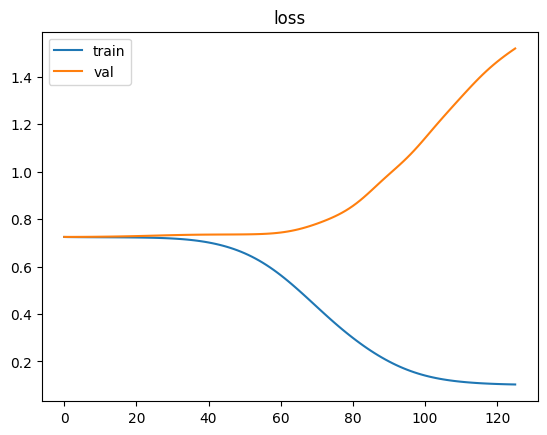

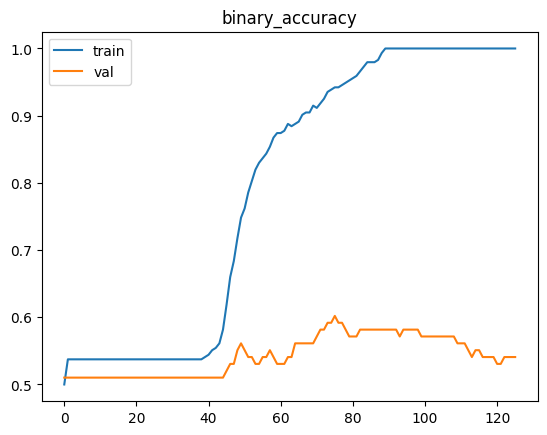

In [140]:
history = model.fit(train, n_epochs=200, batch_size=150, val_batch_size=50)
fig = plot_metrics(history)

In [141]:
train_result = model.evaluate(train)
test_result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in test_result.items():
    print(f'test_{measure}: {value}')

train_loss: 0.4720828966660933
train_binary_accuracy: 0.8556618853048845
test_loss: 0.8092610131610524
test_binary_accuracy: 0.6079545454545454


In [777]:
model.state_dict().keys()

odict_keys(['unmixing_layer.weight', 'unmixing_layer.bias', 'temp_conv.weight', 'temp_conv.bias', 'temp_sel.0.w1', 'temp_sel.0.w2', 'temp_sel.0.b', 'temp_sel.1.w1', 'temp_sel.1.w2', 'temp_sel.1.b', 'temp_sel.2.w1', 'temp_sel.2.w2', 'temp_sel.2.b', 'temp_sel.3.w1', 'temp_sel.3.w2', 'temp_sel.3.b', 'temp_sel.4.w1', 'temp_sel.4.w2', 'temp_sel.4.b', 'temp_sel.5.w1', 'temp_sel.5.w2', 'temp_sel.5.b', 'temp_sel.6.w1', 'temp_sel.6.w2', 'temp_sel.6.b', 'temp_sel.7.w1', 'temp_sel.7.w2', 'temp_sel.7.b', 'fc_layer.weight', 'fc_layer.bias'])

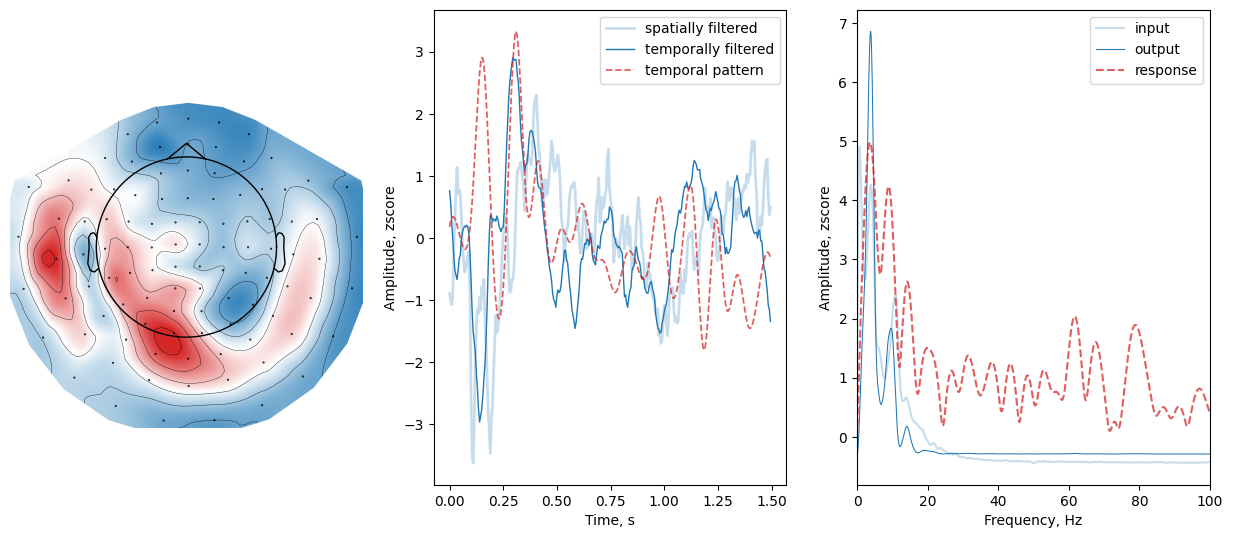

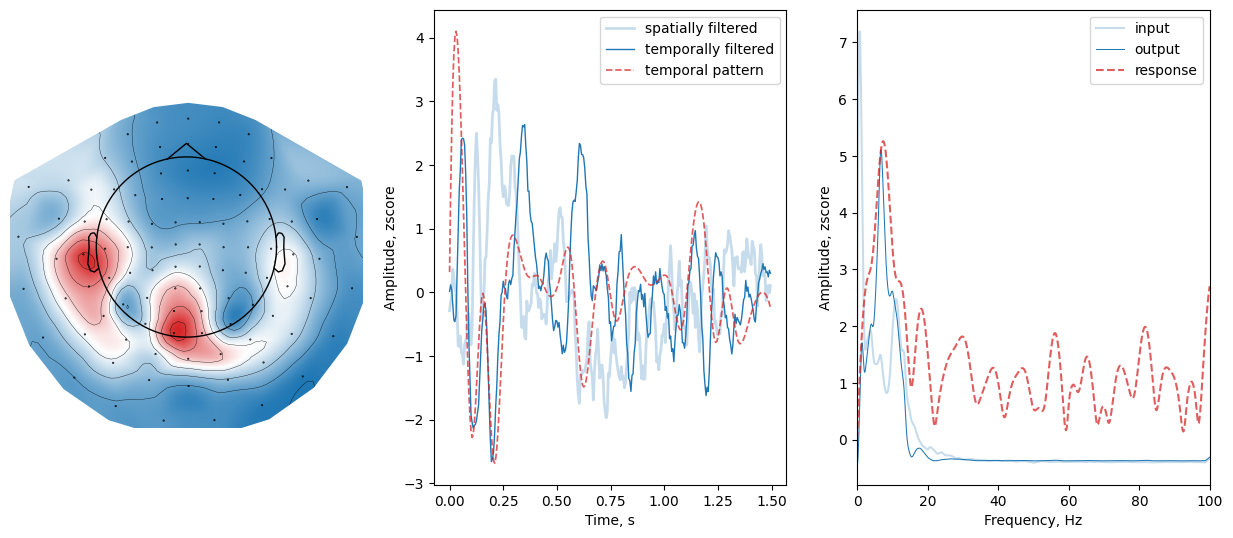

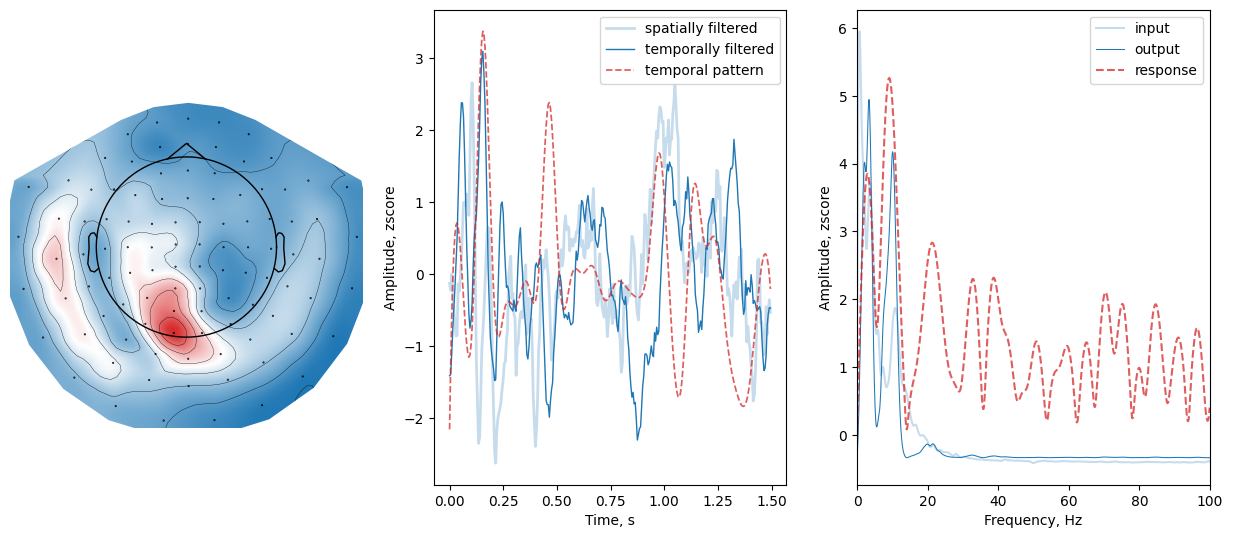

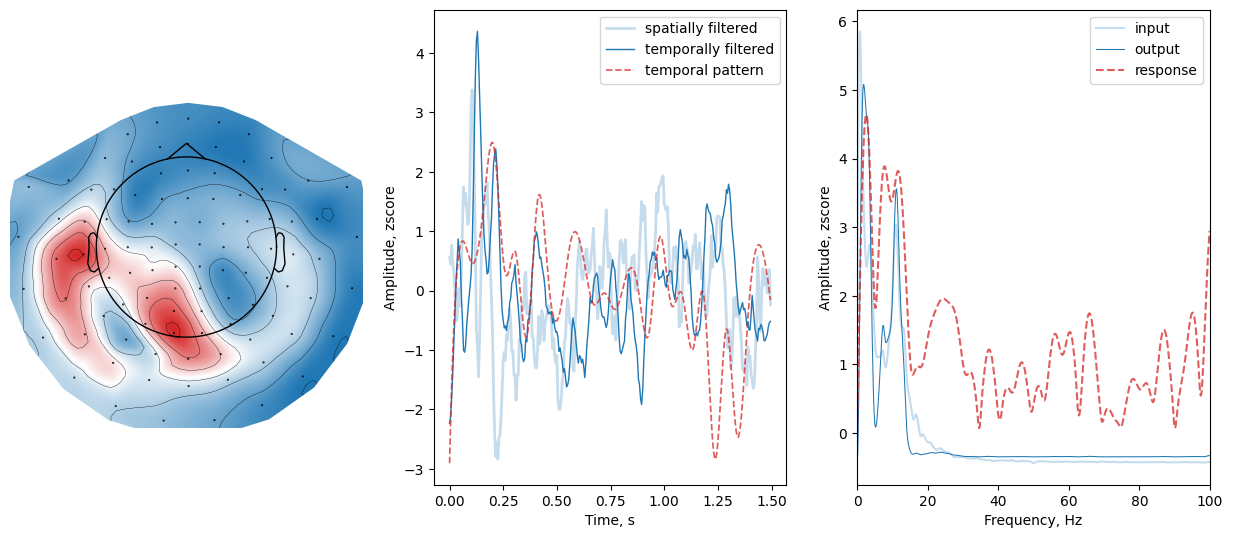

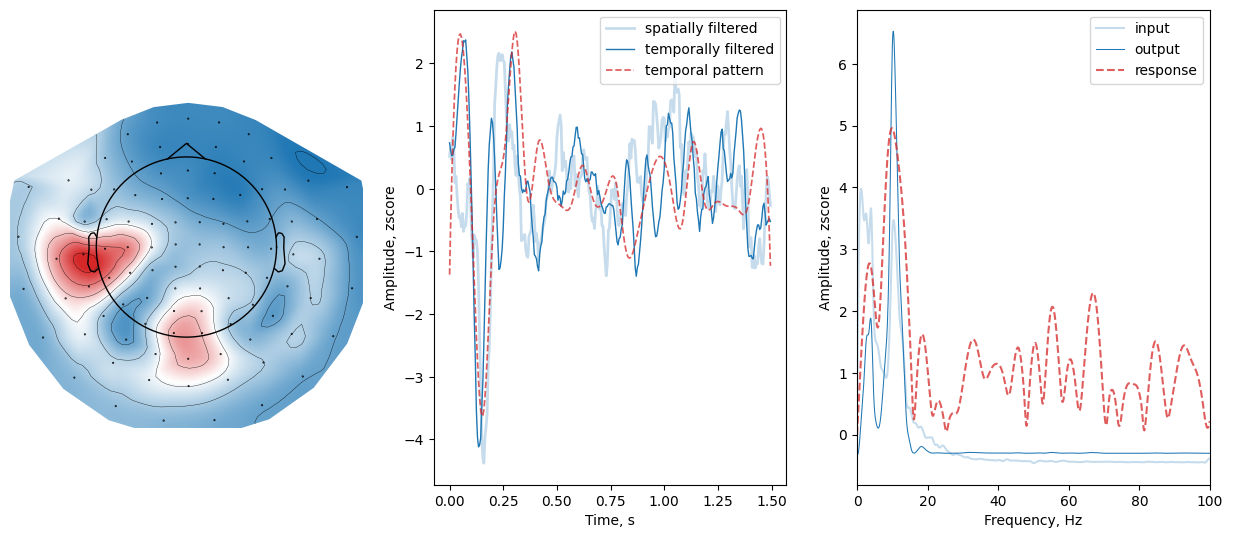

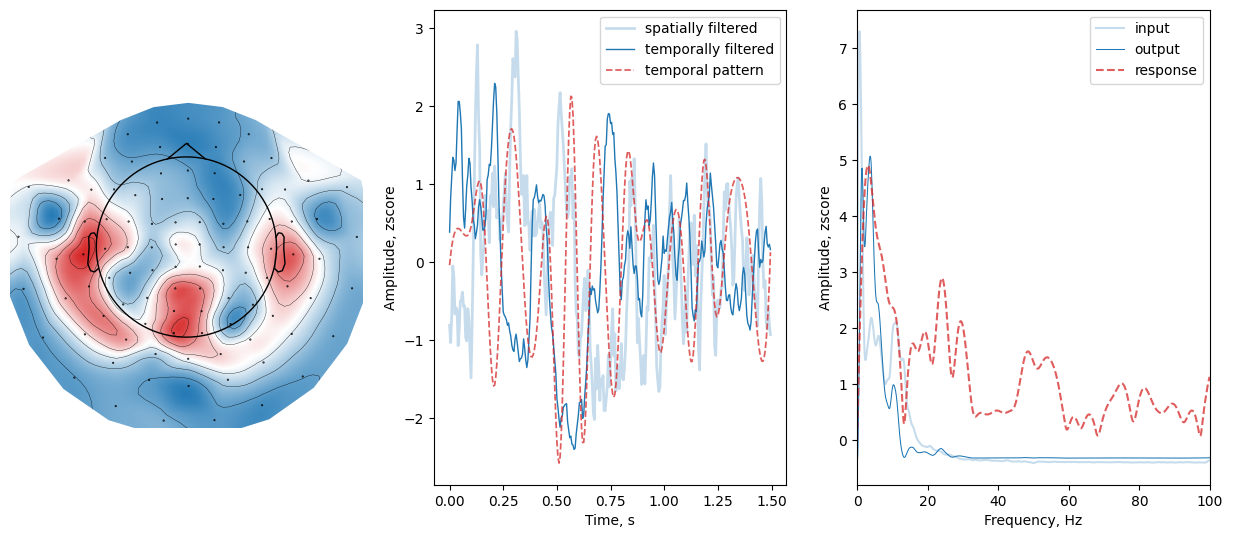

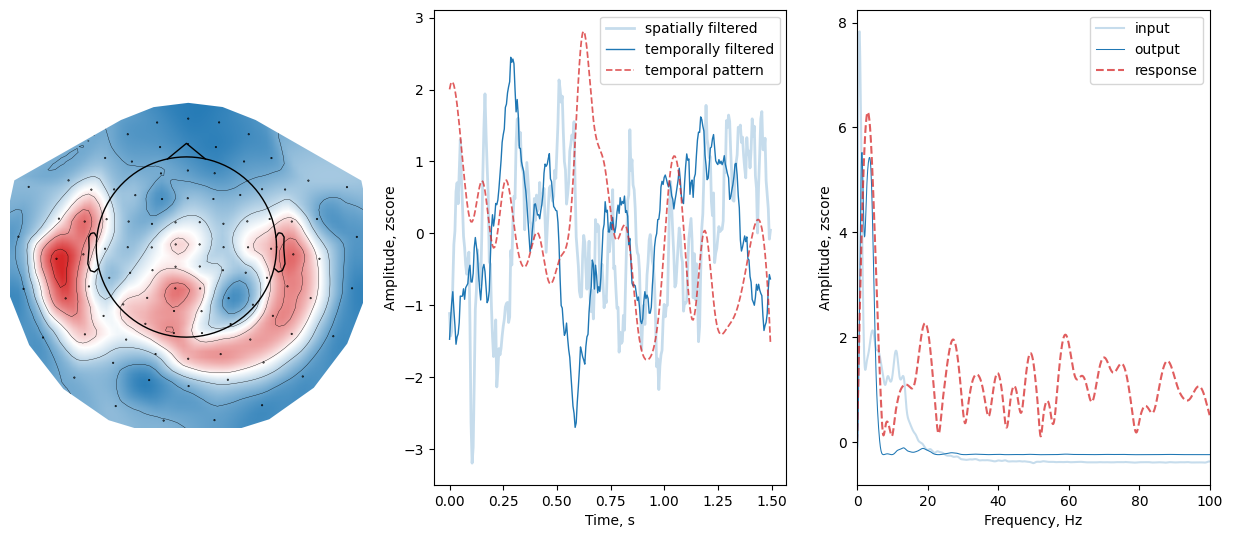

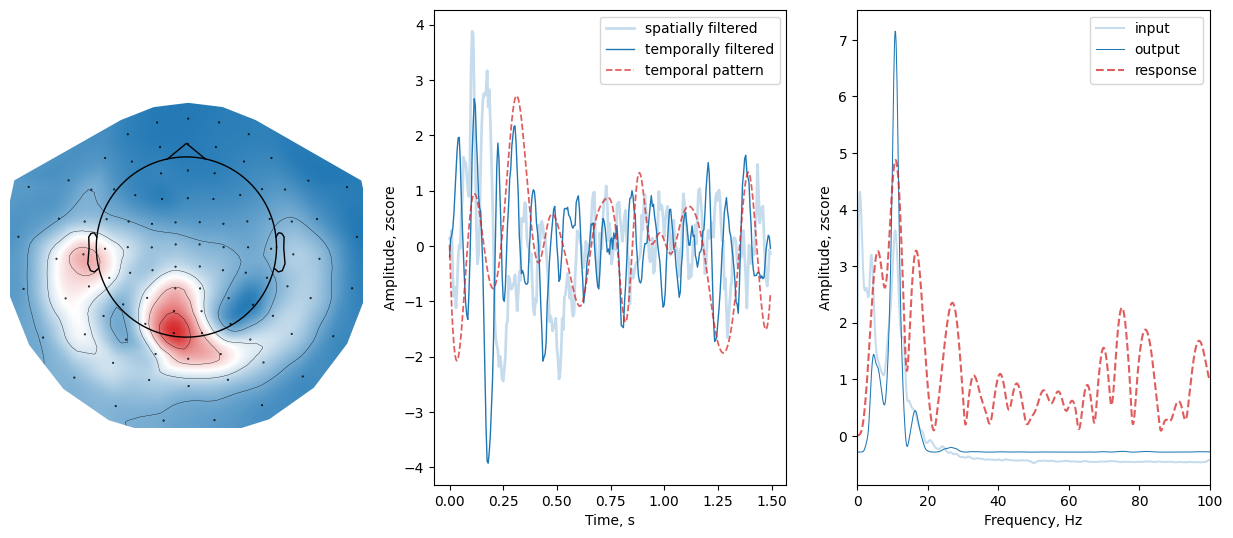

In [143]:
from deepmeg.experimental.interpreters import SPIRITInterpreter, LFCNNWInterpreter
# interpretation = SPIRITInterpreter(model, test, info)
interpretation = LFCNNWInterpreter(model, test, info)
for i in range(8):
    interpretation.plot_branch(i)
    plt.show()

In [49]:
from torch.utils.data import DataLoader
s, t = next(iter(DataLoader(train, 10)))

In [ ]:
from deepmeg.experimental.layers import LW
from deepmeg.models import BaseModel
import torch
import torch.nn as nn
from deepmeg.experimental.layers import Fourier
from deepmeg.utils.convtools import conviter
import torch.nn as nn
import torch.nn.init as init
import math
import torch
from deepmeg.utils.convtools import compute_output_shape, conviter
import numpy as np

class FourierNorm(nn.Module):

    def __init__(self, n_points, n_components=None):
        super().__init__()

        if n_components is None:
            n_components = n_points//2

        self.layer = Fourier(n_points, n_components)
        self.dp = nn.Dropout(0.5)
        self.bn = nn.BatchNorm1d(n_points)

    def forward(self, x):
        print(x.shape)
        x = self.bn(x)
        x = self.layer(x)
        x = self.dp(x)
        return x

class FourieCov1D(nn.Module):
    def __init__(self, out_channels, window_size, latent_dim = None, overlap=0, stride=1, padding=0, bias=True):
        super().__init__()
        self.window_size = window_size
        self.latent_dim = latent_dim if latent_dim is not None else window_size // 2
        self.overlap = overlap
        self.stride = stride
        self.padding = padding
        self.transform = nn.ModuleList([FourierNorm(self.window_size, self.latent_dim) for _ in range(out_channels)])
        self.transform2 = nn.ModuleList([FourierNorm(self.window_size, self.latent_dim) for _ in range(out_channels)])

        if bias:
            self.bias = nn.Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        # init.uniform_(self.weight, -0.01, 0.01)
        if self.bias is not None:
            init.uniform_(self.bias, -0.01, 0.01)

    def forward(self, X):
        # inputs shape (N_batch, width) ~ (N_batch, n_times)
        X_part1 = X[:, :-(self.window_size - self.overlap)] # shape: (batches, times)
        X_part2 = X[:, self.window_size - self.overlap:,]

        assert X_part1.shape == X_part2.shape, f'Windowed sequence is corrupted: {X_part1.shape} vs {X_part2.shape}'

        convargs = ((X_part1.shape[1], X_part1.shape[0]), self.window_size, self.padding, self.stride)
        n_windows = compute_output_shape(*convargs)[0]
        out_tensor = torch.zeros(X.shape[0], n_windows, len(self.transform)) # ~ batches x n_windows x out_channels

        # iter over neurons
        for n_neuron in range(len(self.transform)):
            for p, q, k in conviter(*convargs):
                # p shape: n_times, ...
                # q shape: n_windows, 0
                # k shape: window_size, ...
                pad_params = list()

                time_range = p[0]
                window_range = k[0]
                n_window = q[0]

                if window_range.start is not None and abs(window_range.start) < self.window_size:
                    pad_params.append(abs(window_range.start))
                else:
                    pad_params.append(0)
                if window_range.stop is not None and abs(window_range.stop) < self.window_size:
                    pad_params.append(abs(window_range.stop))
                else:
                    pad_params.append(0)

                window1 = X_part1[:, time_range]
                window2 = X_part2[:, time_range]
                print(X_part1.shape)

                if pad_params != [0, 0]:
                    window1 = nn.functional.pad(window1, pad_params)
                    window2 = nn.functional.pad(window2, pad_params)

                # weight = self.weight[window_range, :, n_neuron]

                proj1 = self.transform[n_neuron](window1)
                proj2 = self.transform2[n_neuron](window2)

                cov = torch.mean(
                    (proj1 - torch.mean(proj1, 1, keepdim=True))*
                    (proj2 - torch.mean(proj2, 1, keepdim=True)),
                    1,
                    keepdim=True
                ) # ~ (N_batch, 1)
                out_tensor[:, n_window, n_neuron] = torch.squeeze(cov, -1) + self.bias[n_neuron] if self.bias is not None else torch.squeeze(cov, -1)


class FourierSPIRIT(BaseModel):
    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        filter_size: int,
        window_size: int,
        latent_dim: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        self.timesel_list = nn.ModuleList([
            nn.Sequential(
                FourieCov1D(1, window_size, latent_dim, 0, window_size, bias=True),
            )
            for _ in range(n_latent)
        ])
        self.expander = nn.Conv1d(
            in_channels=n_latent,
            out_channels=n_latent,
            kernel_size=(2,),
            padding=1
        )
        self.windows = [win for win, _, _ in conviter((n_times-(window_size),), window_size, 0, window_size)]
        self.windows.append(slice(self.windows[-1].start + window_size, None))
        self.timecomp_list = nn.ModuleList([
            nn.Sequential(
                nn.Linear(
                    n_times,
                    (n_times//pool_factor),
                    bias=False
                ),
                nn.Dropout(.25),
                torch.nn.Sigmoid()
            )
            for i in range(n_latent)
        ])
        final_out_features = (n_times//pool_factor)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)

        x_est = torch.stack(
            [
                timesel(x[:, i, :]) for i, timesel in enumerate(self.timesel_list)
            ],
            1
        )

        x_est = torch.squeeze(x_est, -1)
        x_est = self.expander(x_est)

        x_out = list()
        for i, window in enumerate(self.windows):
            x_out.append(
                x[:, :, window]
                *torch.unsqueeze(x_est[:, :, i], -1)
            )

        x = torch.cat(x_out, -1)

        x = torch.stack(
            [
                timesel(x[:, i, :]) for i, timesel in enumerate(self.timecomp_list)
            ],
            1
        )

        x = torch.flatten(x, 1)
        return self.fc_layer(x)

model = FourierSPIRIT(
    n_channels=X.shape[1],
    n_latent=8,
    n_times=X.shape[-1],
    window_size=20,
    latent_dim=10,
    filter_size=50,
    pool_factor=10,
    n_outputs=Y.shape[1]
)

print(s.shape)

model(s)
